In [83]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
import sys
from scipy.interpolate import interp1d
plt.style.use("~/evanstyle.mplstyle")

sys.path.append("../CombinedData/")
import Dataset

In [84]:
topdir = "../../data/Run8/"
datasets = ["timing-tester-trigsync/"]

ds_single = "timing-tester-trigsync/"
config = "../configs/run8_config.yaml"

In [85]:
#load the dataset object for the single file selected
ds = Dataset.Dataset(topdir+ds_single, config)

no ramp file present at ../../data/Run8/timing-tester-trigsync/ramp.txt, leaving it empty
no g-events-file present at ../../data/Run8/timing-tester-trigsync/g_events.txt, leaving it empty
No ramp data in this dataset


In [86]:
#some example plotting
ex_ad2 = pickle.load(open(ds.ad2_files[0], "rb"))[0]
ex_str = pickle.load(open(ds.struck_files[3], "rb"))[0]

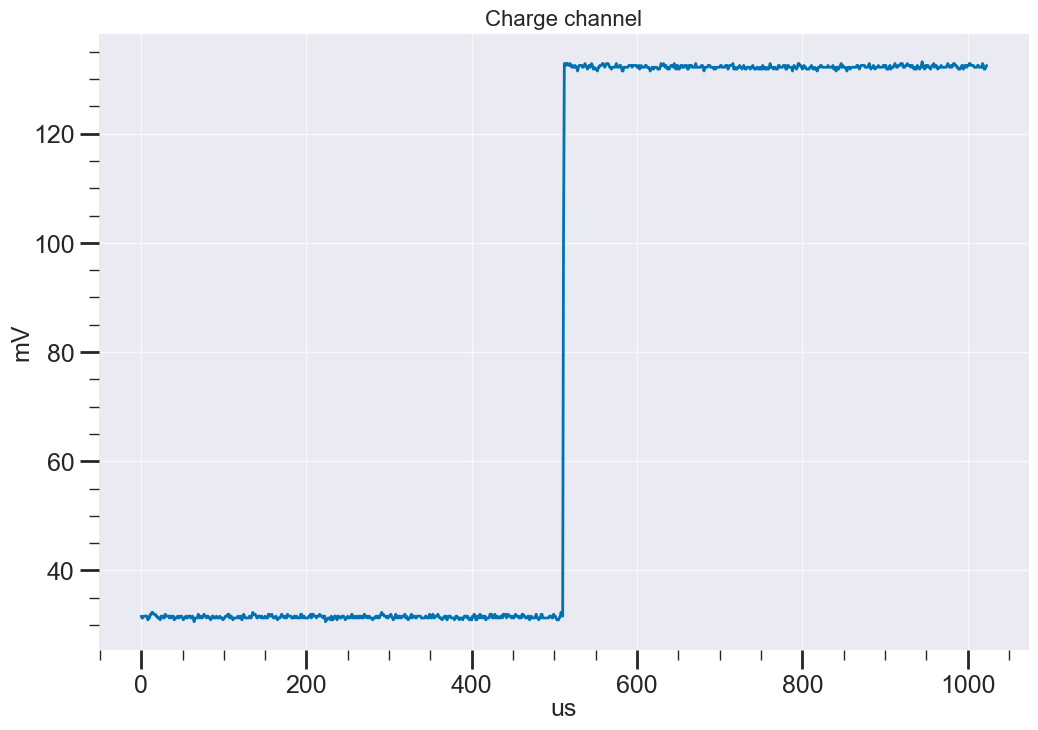

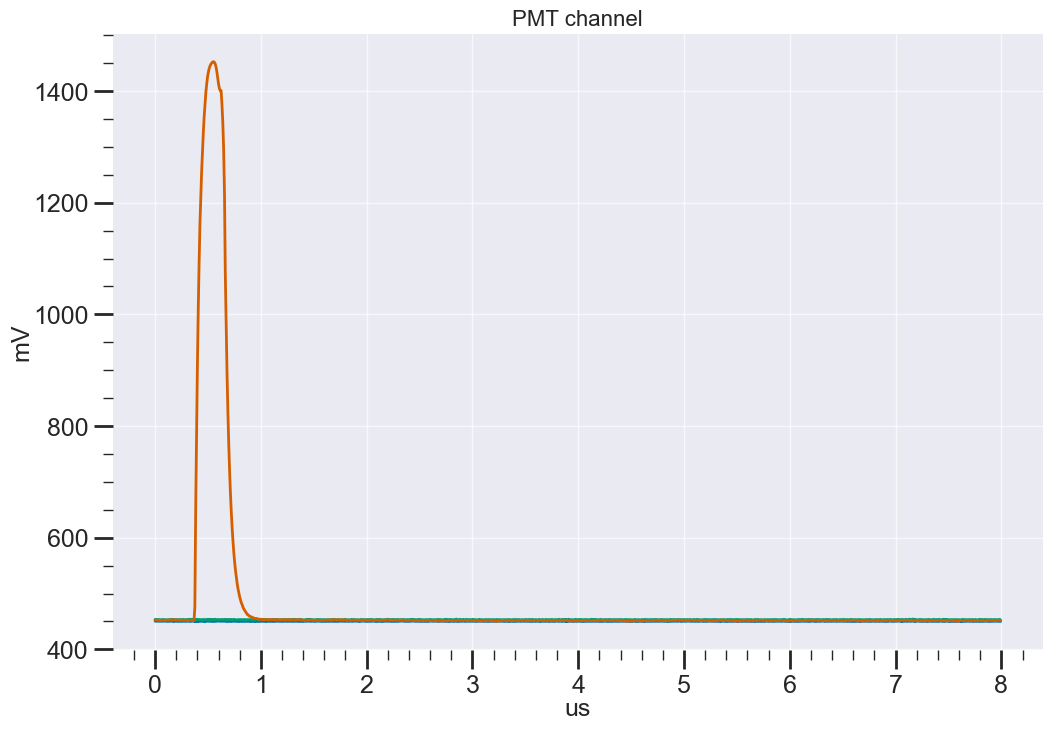

In [87]:
row = ex_ad2.iloc[0]
fig, ax = plt.subplots()

times = np.arange(0, len(row["Data"][0])*row["dT"]*1e6, row["dT"]*1e6) #times in microseconds
ax.plot(times, row["Data"][1])
ax.set_ylabel("mV")
ax.set_xlabel("us")
ax.set_title("Charge channel")
plt.show()

row = ex_str.iloc[470]
fig, ax = plt.subplots()

dT = 1/float(ds.config["struck_reduction"]["clock"])
times = np.arange(0, (len(row["Data"][0]) - 1)*dT*1e6, dT*1e6) #times in microseconds
ax.plot(times, row["Data"][0])
ax.plot(times, row["Data"][1])
ax.plot(times, row["Data"][2])
ax.set_ylabel("mV")
ax.set_xlabel("us")
ax.set_title("PMT channel")
plt.show()

In [88]:
#threshold crossing distribution on PMT timing signal
#really simple, just curious, to see if it matters at all. 
thr = 200 #mV
dT = 1/float(ds.config["struck_reduction"]["clock"])
time_of_arrivals = [] 
for i, f in enumerate(ds.struck_files):
    df = pickle.load(open(f, "rb"))[0]
    for j, row in df.iterrows():
        v = row["Data"][2]
        v_bl = np.mean(v[:40])
        v = v - v_bl
        thr_cr = np.where(v > thr)
        fc = np.min(thr_cr) #fc is short for first crossing
        #the threshold crossing is within a sample, so lets get more precise with interpolation. 
        s = interp1d(v[fc-2:fc+2], np.array(range(len(v)))[fc-2:fc+2])
        toa = s(thr)*dT*1e6
        time_of_arrivals.append(toa)
        """
        fig, ax = plt.subplots()
        ax.plot(range(len(v)), v)
        ax.scatter([fc], v[fc], s=100)
        ax.plot(np.array(range(len(v)))[fc-2:fc+2], v[fc-2:fc+2])
        ax.axvline(toa/dT/1e6)
        ax.axhline(thr)
        ax.set_xlim([40, 60])
        plt.show()
        """


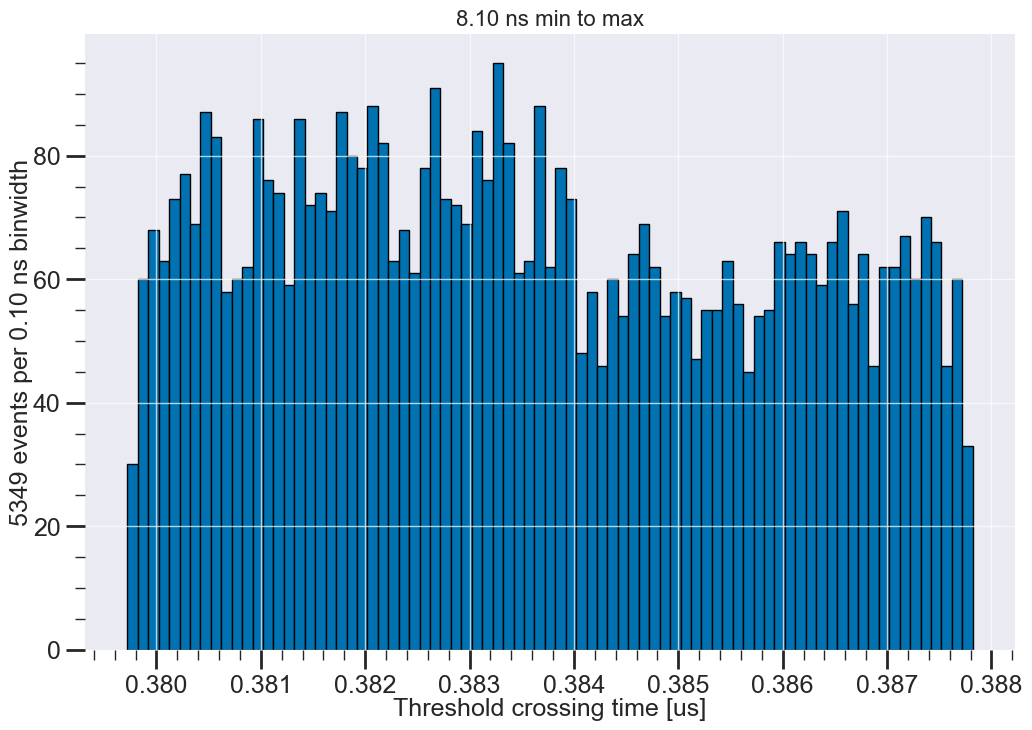

In [89]:
fig, ax = plt.subplots()
h = time_of_arrivals
binwidth = 0.0001 #us
bins = np.arange(min(h), max(h), binwidth)
ax.hist(h, bins=bins)
ax.set_xlabel("Threshold crossing time [us]")
ax.set_ylabel("{:d} events per {:.2f} ns binwidth".format(len(h), binwidth*1000))
ax.set_title("{:.2f} ns min to max".format((max(h) - min(h))*1000))
plt.show()

In [90]:
#Attempt to identify timestamps across AD2 and Struck 

ad2_df = pickle.load(open(ds.ad2_files[0], "rb"))[0] #we know there is only one ad2 file. this is custom code for a specific purpose...
all_time_diffs = []
#use each struck even and loop through the AD2 events to find coincidence. 
for i, f in enumerate(ds.struck_files):
    df = pickle.load(open(f, "rb"))[0]
    for j, ev in df.iterrows():
        #sync channel timing parameters to find coincidence with. 
        t0 = ev["Seconds"]
        t0_ns = ev["Nanoseconds"]

        #look in the ad2_df and mask out anything outside of a certain window. 
        coinc = 0 #seconds
        coinc_ns = 0.1e9 #nanoseconds
        mask = ((ad2_df["Seconds"] - (t0 - coinc) + ((ad2_df["Nanoseconds"] - (t0_ns - coinc_ns))/1e9)) >= 0) &\
                    ((ad2_df["Seconds"] - (t0 + coinc) + ((ad2_df["Nanoseconds"] - (t0_ns + coinc_ns))/1e9)) <= 0) 
        selected = ad2_df[mask]
        nsel = len(selected.index)
        if(nsel == 0): 
            print("no event within {:.2f} milliseconds".format(coinc_ns/1e9))
            continue
        
        if(nsel > 1):
            print("multiple events found within coincidence window")
            tdiffs = []
            for _, sel in selected.iterrows():
                tdiffs.append(sel["Seconds"] - t0 + (sel["Nanoseconds"] - t0_ns)/1e9)
            all_time_diffs.append(min(tdiffs)) #this is where you may find strange things in statistical distribution
        else:
            sel = selected.iloc[0]
            all_time_diffs.append(sel["Seconds"] - t0 + (sel["Nanoseconds"] - t0_ns)/1e9)



no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event within 0.10 milliseconds
no event withi

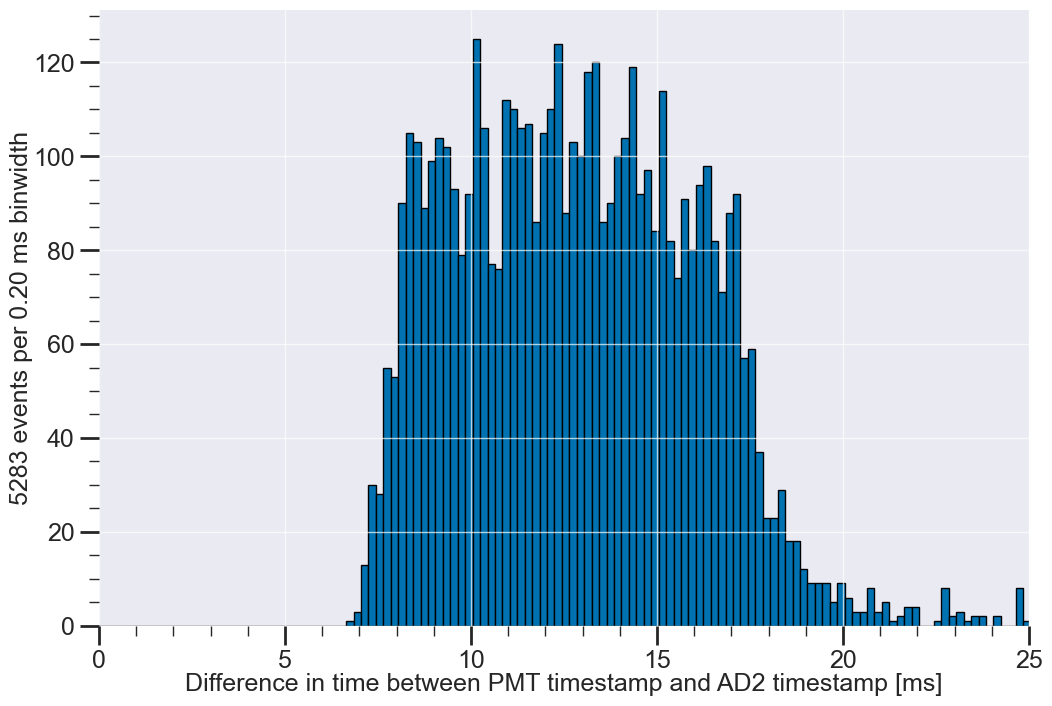

In [93]:
fig, ax = plt.subplots()
h = np.array(all_time_diffs)*1e3
binwidth = 0.2 #milliseconds
bins = np.arange(min(h), max(h), binwidth)
ax.hist(h, bins=bins)
ax.set_xlabel("Difference in time between PMT timestamp and AD2 timestamp [ms]")
ax.set_ylabel("{:d} events per {:.2f} ms binwidth".format(len(h), binwidth))
#ax.set_title("{:.2f} ns min to max".format((max(h) - min(h))*1000))
ax.set_xlim([0, 25])
plt.show()